In [2]:
# Goal: Plots and Graphs for Anders Meeting
import sys, os, functools
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import astropy.constants as aconst
import astropy.units as u
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import astropy.table as table
from astropy.cosmology import Planck15 as cosmology

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.blackbody as blackbody
import snelib19odp.specds as specds
import snelib19odp.analysis.spec_model as spec_model

In [4]:
sds = specds.load_dataset('SN2019odp')
SPECS = {
    'not_late': (sds['ZTF19abqwtfu_20200113_NOT_v1'], {'scale_factor': np.sqrt(2)/9.395640563324519e-18,}),
    'keck_early': (sds['ZTF19abqwtfu_20200124_Keck1_v1'], {'scale_factor': np.sqrt(2)/7.002413899090286e-18,}),
    'keck_late': (sds['ZTF19abqwtfu_20200821_Keck1_v1'], {'scale_factor': np.sqrt(2)/3.031557125203086e-18, 'start5577': 5520, 'stop5577': 5669, 'start6300_6364': 6150,})
}

In [ ]:
# Agenda
# * manual optical depth estimate
# * optical depth plot..
# * model descriptions
# * model fits
# * difference to manul estimate - maybe gaussian not best choice? parabolic?

In [3]:
# Manual optical depth estimates
# keck_early no_continuum_sub -> R~1.52 => tau~3.0
# keck_early continuum_sub -> R~1.65 => tau~2.7
# keck_late no_continuum_sub -> R~2.5 => tau~0.75
# keck_late continuum_sub -> R~3.0 => tau~0

In [5]:
# Optical depth plot
def ratio_decompose(name, label, continuum=0, remove_ratio=1.0):
    s = sds[name]
    s = s[~np.isnan(s['flux'])]
    idx = np.logical_and(s['restwave'] > 6100, s['restwave'] < 6500)
    s = s[idx]
    s.sort('restwave', reverse=True)
    c = 299792.458
    velocity6300 = (6300/s['restwave']-1)*c
    velocity6364 = (6364/s['restwave']-1)*c
    
    v_grid = np.linspace(-8000,6000)
    finterp6300 = np.interp(v_grid, velocity6300, s['flux']-continuum)
    finterp6364 = np.interp(v_grid, velocity6364, s['flux']-continuum)
    finterp6364B = np.interp(v_grid, velocity6364+3300, s['flux']-continuum)
    plt.plot(v_grid, finterp6300/(finterp6364-finterp6364B*remove_ratio), label=label)
    #plt.plot(v_grid, finterp6300, label=label)
    x = table.Table({'restwave': s['restwave'], 'v6300': velocity6300, 'v6364': velocity6364})
    #print(velocity6300-velocity6364)
    #x.pprint()

(0.0, 3.0)

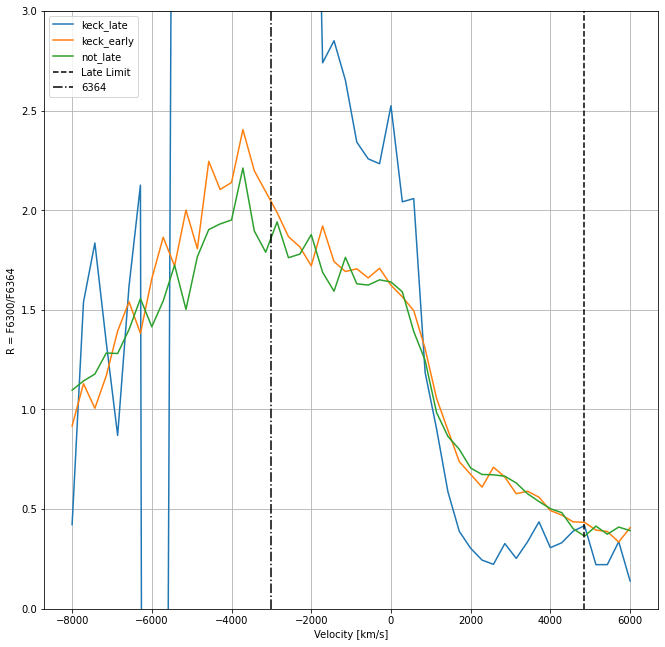

In [11]:
plt.figure(figsize=(11,11))
ratio_decompose('ZTF19abqwtfu_20200821_Keck1_v1', 'keck_late', continuum=0.3e-17, remove_ratio=0.0)
ratio_decompose('ZTF19abqwtfu_20200124_Keck1_v1', 'keck_early', continuum=0.5e-16, remove_ratio=0.0)
ratio_decompose('ZTF19abqwtfu_20200113_NOT_v1', 'not_late', continuum=0.7e-16, remove_ratio=0.0)

plt.xlabel('Velocity [km/s]')
plt.ylabel('R = F6300/F6364')
c = 299792.458
plt.axvline((6300/6200-1)*c, label='Late Limit', ls='--', color='black')
plt.axvline((6300/6364-1)*c, label='6364', ls='-.', color='black')
plt.legend()
plt.grid()
plt.ylim((0,3))

<ipython-input-5-fd933fe94f5e>:16: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(v_grid, finterp6300/(finterp6364-finterp6364B*remove_ratio), label=label)
<ipython-input-5-fd933fe94f5e>:16: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(v_grid, finterp6300/(finterp6364-finterp6364B*remove_ratio), label=label)
<ipython-input-5-fd933fe94f5e>:16: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(v_grid, finterp6300/(finterp6364-finterp6364B*remove_ratio), label=label)


(0.0, 3.0)

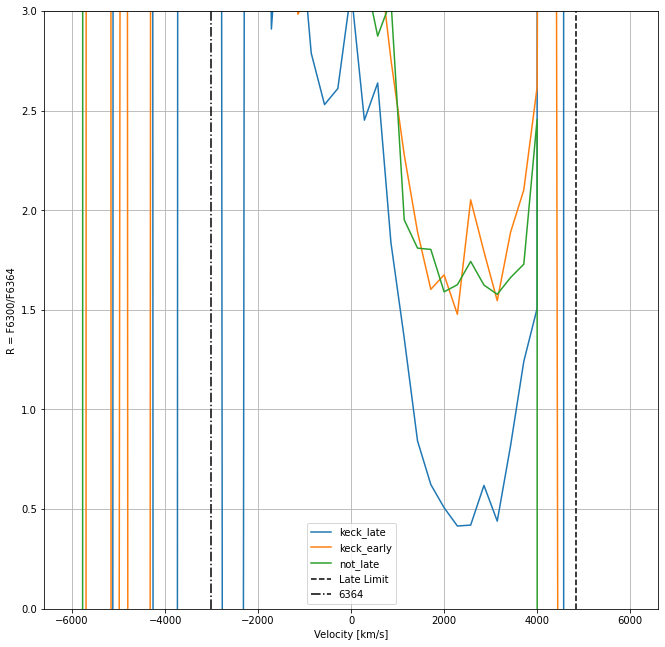

In [16]:
plt.figure(figsize=(11,11))
ratio_decompose('ZTF19abqwtfu_20200821_Keck1_v1', 'keck_late', continuum=0.2e-17, remove_ratio=1.0)
ratio_decompose('ZTF19abqwtfu_20200124_Keck1_v1', 'keck_early', continuum=0.3e-16, remove_ratio=1.0)
ratio_decompose('ZTF19abqwtfu_20200113_NOT_v1', 'not_late', continuum=0.7e-16, remove_ratio=1.0)

plt.xlabel('Velocity [km/s]')
plt.ylabel('R = F6300/F6364')
c = 299792.458
plt.axvline((6300/6200-1)*c, label='Late Limit', ls='--', color='black')
plt.axvline((6300/6364-1)*c, label='6364', ls='-.', color='black')
plt.legend()
plt.grid()
plt.ylim((0,3))

In [12]:
# Model Description
# * multiline -> additional 5500, 6158, 6230, 6454 lines
# * snglline -> no extra lines
# * nlte0.1 -> max_nlte_deviation=0.1
# * nlte0.95 -> max_nlte_deviation=0.95
MODEL_PREFIX = 'oxygen_tau_'
MODELS = {
    'full_multiline_nlte0.1': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14),
    'full_multiline_nlte0.95': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14),
    'full_snglline_nlte0.1': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1,  max_extra_line_amp=3e-14),
    'full_snglline_nlte0.95': oxygen.FitSetup(spec=None, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=26, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.95,  max_extra_line_amp=3e-14)

}

SAMPLER_PARAMS = {
    'nlive_points': 5000,
    'dynesty_method': 'rwalk'
}

def make_model(model, spec_name, no_cache=False):
    cfg = MODELS[model]
    spec, overrides = SPECS[spec_name]
    spec = spec[~np.isnan(spec['flux'])]
    params = cfg._replace(**overrides)
    
    model_name = MODEL_PREFIX + model + '_' + spec_name
    if no_cache:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS, cache_options=set(['ignore-cache']))
    else:
        return spec_model.load_or_make(model_name, spec, 'oxygen_gaussline', params, SAMPLER_PARAMS)

In [13]:
def extract_trace(specmod, idx):
    specmod.run()
    trace = specmod.samples
    return trace[:,idx]

extract_model_moi = functools.partial(extract_trace, idx=0)
extract_model_temp = functools.partial(extract_trace, idx=1)
extract_model_line_width = functools.partial(extract_trace, idx=2)
extract_model_optical_depth6300 = functools.partial(extract_trace, idx=9)


def extract_model_line_velocity(specmod):
    width = extract_model_line_width(specmod)
    velocity_sigma = width/6300 * 299792.458
    return 2*np.sqrt(np.log(2)) * velocity_sigma

In [14]:
print('Compare MOI estimate from model with optical_depth based estimate')
print('Columns: model spectrum moi_from_model moi_from_optical_depth')
print('Percentiles are [5%, 50%, 95%]')

for mod_name in MODELS.keys():
    for spec_name in SPECS.keys():
        specmod = make_model(mod_name, spec_name)
        spec_time = specmod.spec.meta['obs_mjd'] - 58714.5
        spec_time *= 3600*24
        #print(specmod.spec.meta)
        
        line_velocity = extract_model_line_velocity(specmod)
        tau6300 = extract_model_optical_depth6300(specmod)
        model_moi = extract_model_moi(specmod)
        inferred_moi = tau6300/oxygen.optical_depth_from_line_volume(6300, 1.0, line_velocity, spec_time,fill_factor=1.0)
        p1 = np.percentile(model_moi, [5, 50, 95])
        p2 = np.percentile(inferred_moi, [5, 50, 95])
        print(mod_name, spec_name, p1, p2)
        #p = np.percentile(extract_model_line_width(specmod), [25, 50, 75])
        #print(mod_name, spec_name, p)

Compare MOI estimate from model with optical_depth based estimate
Columns: model spectrum moi_from_model moi_from_optical_depth
Percentiles are [5%, 50%, 95%]
full_multiline_nlte0.1 not_late [0.77190534 3.01215632 5.56649007] [5.62368908 7.01241175 8.71395781]
full_multiline_nlte0.1 keck_early [0.61728148 2.61956012 5.35076287] [7.40307834 8.50901315 9.74751263]
full_multiline_nlte0.1 keck_late [0.42602674 2.58515662 5.42687544] [10.36535776 13.21560935 16.38756331]
full_multiline_nlte0.95 not_late [5.2131851  5.76983894 5.97423828] [3.61224217 4.40320411 5.18924715]
full_multiline_nlte0.95 keck_early [5.6329493  5.89692146 5.98852842] [4.82025186 5.35603748 5.89866268]
full_multiline_nlte0.95 keck_late [2.53273512 4.3369713  5.75248101] [10.07106744 13.04184631 16.50025919]
full_snglline_nlte0.1 not_late [0.45561548 2.38572364 5.36090524] [0.43168311 1.40465387 3.69493105]
full_snglline_nlte0.1 keck_early [0.29092661 1.42517121 3.34887988] [0.50303702 1.3857351  3.03953267]
full_sngll

In [15]:
# estimate optical depth at 368d post explosion
print('Predict optical depth at texpl+368d from previous spectra')
print('Percentiles are [5%, 50%, 95%]')
print('keck_late is the measured optical depth\n')
phase_late = 368*24*3600
phase_late /= (1+0.014353)
for mod_name in MODELS.keys():
    for spec_name in SPECS.keys():
        specmod = make_model(mod_name, spec_name)
        spec_time = specmod.spec.meta['obs_mjd'] - 58714.5
        spec_time *= 3600*24
        spec_time /= (1+0.014353)
        #print(specmod.spec.meta)
        
        line_velocity = extract_model_line_velocity(specmod)
        tau6300 = extract_model_optical_depth6300(specmod)
        
        if spec_name == 'keck_late':
            p = np.percentile(tau6300, [5, 50, 95])
            print(mod_name, '<<%s>>' % spec_name, p)
        else:
            tau6300_late = tau6300*spec_time**2 / phase_late**2
            p = np.percentile(tau6300_late, [10, 50, 75])
            print(mod_name, spec_name, p)

Predict optical depth at texpl+368d from previous spectra
Percentiles are [5%, 50%, 95%]
keck_late is the measured optical depth

full_multiline_nlte0.1 not_late [0.38432335 0.45540995 0.49734854]
full_multiline_nlte0.1 keck_early [0.49324145 0.54871729 0.57937183]
full_multiline_nlte0.1 <<keck_late>> [1.08201695 1.35233184 1.63152834]
full_multiline_nlte0.95 not_late [0.24667806 0.28603647 0.30666999]
full_multiline_nlte0.95 keck_early [0.31848682 0.34538732 0.35967848]
full_multiline_nlte0.95 <<keck_late>> [1.05735203 1.33522581 1.63058102]
full_snglline_nlte0.1 not_late [0.03465069 0.09287799 0.14781944]
full_snglline_nlte0.1 keck_early [0.03912989 0.08990357 0.1299383 ]
full_snglline_nlte0.1 <<keck_late>> [0.56978599 0.89579274 1.23387801]
full_snglline_nlte0.95 not_late [0.03047455 0.06656019 0.10361796]
full_snglline_nlte0.95 keck_early [0.03934169 0.09063549 0.13090925]
full_snglline_nlte0.95 <<keck_late>> [0.54020681 0.86729787 1.21298381]


In [20]:
specmod = make_model('full_snglline_nlte0.1', 'keck_late')
specmod.samples[52]

array([ 2.68671543e+00,  3.18859805e+03,  2.50110138e+01,  2.15215893e+00,
        3.08472235e+00,  3.05936196e-03,  4.73564460e-03,  1.98012288e+26,
       -4.18201257e-01,  8.79838039e-01, -2.01166321e+00,  2.76087819e-01])